In [5]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim

### Download data

In [31]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
12,2020-02-11,0,0,0


In [81]:
df[37:].head()

,date,confirmed,deceased,recovered
37,2020-03-07,3,0,0
38,2020-03-08,5,0,0
39,2020-03-09,9,0,0
40,2020-03-10,15,0,1
41,2020-03-11,8,0,0


### Prep data

In [84]:
cnf = np.array(df['confirmed'][37:].rolling(6, center=True, min_periods=1).mean()) / 10000
# data to be prepped in the form of seq_len, batch, num_inputs. so 3, 1, 1
dl = len(cnf) - 3 # dataset length
ip = torch.tensor(np.array([cnf[:-3], cnf[1:-2], cnf[2:-1]]).reshape(dl, 3, 1, 1), dtype=torch.float32)
op = torch.tensor(np.array(cnf[3:]), dtype=torch.float32)

### Define RNN

In [79]:
model = tnn.RNN(input_size=1, hidden_size=1)

loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=0.1)

### Train

Iter: 0 Loss: 0.18828165531158447 Out: 0.4347476661205292 Ex: 8.333333535119891
Iter: 10 Loss: 0.03036595694720745 Out: -0.1696416437625885 Ex: 46.166665852069855
Iter: 20 Loss: 0.0044716461561620235 Out: 0.08902037143707275 Ex: 221.5000055730343
Iter: 30 Loss: 2.475817200320307e-05 Out: 0.0743090882897377 Ex: 693.3332979679108
Iter: 40 Loss: 0.0002666865475475788 Out: 0.11216945946216583 Ex: 1284.9999964237213
Iter: 50 Loss: 0.0014455498894676566 Out: 0.14496295154094696 Ex: 1829.8333883285522
Iter: 60 Loss: 5.747375325881876e-05 Out: 0.36363115906715393 Ex: 3560.500144958496


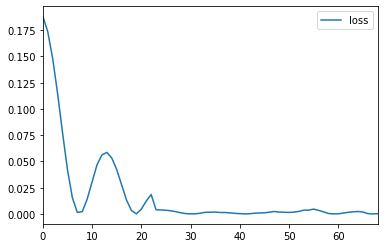

In [85]:
loss_vals = []
pred_vals = []
# h = torch.tensor(np.array([0]).reshape(1, 1, 1), dtype=torch.float32)
for i in range(dl):
    _, pred = model(ip[i%dl])
    loss = loss_fn(pred, op[i%dl])

    loss_vals.append(loss.item())
    if i%10 == 0:
        print("Iter:", i, "Loss:", loss.item(), "Out:", pred.item(), "Ex:", op[i%dl].item()*10000)
#         print(model.state_dict())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

df_loss = pd.DataFrame({
    'loss': loss_vals
})
df_loss.plot(
    y='loss'
)

### Test
- on a single value

In [93]:
test_in = np.array([1000, 2000, 3000]) / 10000
t = torch.tensor(
    test_in.reshape(3, 1, 1),
    dtype=torch.float32
)
_, out = model(t)
print(out.item() * 10000)

4185.094833374023


- on entire input

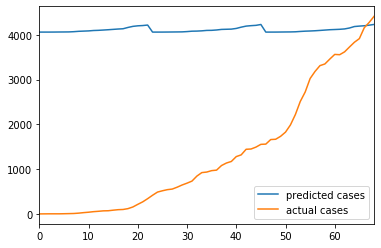

In [96]:
pred_vals = []
out_vals = []
for idx,i in enumerate(ip):
    _, pred = model(i)
    pred_vals.append(pred.item() * 10000)
    out_vals.append(op[idx].item() * 10000)

cmp_df = pd.DataFrame({
    'predicted cases': pred_vals,
    'actual cases': out_vals
})
cmp_df.plot()


In [88]:
model.state_dict()

OrderedDict([('weight_ih_l0', tensor([[0.0673]])),
             ('weight_hh_l0', tensor([[-0.4806]])),
             ('bias_ih_l0', tensor([0.8094])),
             ('bias_hh_l0', tensor([-0.2252]))])